In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.patches as patches
import matplotlib.lines as lines


import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

from definition.forEKE import *

%matplotlib inline

In [2]:
def _adjust_grid(ds):
        # relevant to regular/analytical grid for now
        #
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])
        
        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})
                
        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 
        
        # rename coordinates 
#         eta_suff={}
#         for c in ds.coords:
#             new_c = c.replace('nav_lat','eta').replace('nav_lon','xi')
#             ds = ds.rename({c:new_c})
#             # reset names and units
#             ds[new_c] = (ds[new_c].assign_attrs(units='m', 
#                                                standard_name=new_c,
#                                                long_name=new_c)
#                         )
        # Create xgcm grid
        coords={'xi':{'center':'x_rho', 'inner':'x_u'}, 
                'eta':{'center':'y_rho', 'inner':'y_v'}, 
                's':{'center':'s_rho', 'outer':'s_w'}}
        ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords)
        
        return ds

In [3]:
from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=6)
client = Client(cluster)
client

<Client: 'inproc://192.168.1.12/23616/1' processes=1 threads=6, memory=33.67 GB>

In [4]:
fileEKE='/media/durand/GIGATL/Temp/KE/EKE.nc'
fileKE='/media/durand/GIGATL/Temp/KE/KE_tot.nc'

# Create different dataset for KE_mean
ds = xr.open_dataset(fileEKE, chunks={'s_rho': 1})
ds_KEtot = xr.open_dataset(fileKE, chunks={'s_rho': 1})

In [5]:
path="/media/durand/GIGATL/Temp/data/"
gridname = path+'GIGATL6_12h_inst_2004-01-15-2004-01-19.nc'
gd = xr.open_dataset(gridname, chunks={'s_rho': 1})
ds['hc'] = gd.hc
ds['h'] = gd.h
ds['Vtransform'] = gd.Vtransform
ds['sc_r'] = gd.sc_r
ds['sc_w'] = gd.sc_w
ds['Cs_r'] = gd.Cs_r
ds['Cs_w'] = gd.Cs_w
ds['angle'] = gd.angle
ds['mask_rho'] = gd.mask_rho


In [6]:
ds = _adjust_grid(ds)
L = ds.dims['x_rho']
M = ds.dims['y_rho']
N = ds.dims['s_rho']
ds = xgcm_grid(ds)
grid = ds.attrs['xgcm-Grid']

In [21]:
### for spécifique Depth

#compute depth
z = get_z(ds,hgrid='r').load()

#compute total and stock EKE
EKE_Total = (ds.EKEu+ds.EKEv).load()
EKE_u = ds.EKEu.load()
EKE_v = ds.EKEv.load()

#compute total and stock KE
KE_tot=(ds_KEtot.keU+ds_KEtot.keV).load()
KE_u = ds_KEtot.keU.load()
KE_v = ds_KEtot.keV.load()

## Calcul Rapport
KE_Total_rapport=(EKE_Total/(KE_tot-EKE_Total)).load()
KE_u_rapport = (EKE_u/(KE_u-EKE_u)).load()
KE_v_rapport = (EKE_v/(KE_v-EKE_v)).load()


# EKE_Int_Total=ds.EKEu_Int+ds.EKEv_Int

/home/durand/croco/KEanalysis/definition/forEKE.py:168: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(*(zdim,)+_zeta.dims)


In [8]:
# plt.figure(figsize=(15,6), dpi=80)


# EKE_Int_Total.plot(x=[s for s in ds.coords if "xi_" in s][0],
#                        y=[s for s in ds.coords if "eta_" in s][0],
#                      vmin=0,vmax=0.020,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

# EKE_Int_Total.plot.contour(x=[s for s in ds_KEtot.coords if "xi_" in s][0],
#                              y=[s for s in ds_KEtot.coords if "eta_" in s][0],
#                              vmin=0,vmax=0.02,levels=11,colors='black',
#                              linewidths=0.5)

# plt.xlim(-60,10)
# plt.ylim(-20,20)
# plt.xlabel('Longitude')
# plt.ylabel('latitude')
# plt.axhline(y=-0.,color='black',linewidth=1)
# plt.title('Energie cinétique turbulente totale Integré')
# plt.grid()  
# ax = plt.gca()
# ax.set_facecolor('darkkhaki')

In [9]:
# plt.figure(figsize=(15,6), dpi=80)


# ds.EKEu_Int.plot(x=[s for s in ds.coords if "xi_" in s][0],
#                        y=[s for s in ds.coords if "eta_" in s][0],
#                      vmin=0,vmax=0.020,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

# ds.EKEu_Int.plot.contour(x=[s for s in ds_KEtot.coords if "xi_" in s][0],
#                              y=[s for s in ds_KEtot.coords if "eta_" in s][0],
#                              vmin=0,vmax=0.02,levels=11,colors='black',
#                              linewidths=0.5)

# plt.xlim(-60,10)
# plt.ylim(-20,20)
# plt.xlabel('Longitude')
# plt.ylabel('latitude')
# plt.axhline(y=-0.,color='black',linewidth=1)
# plt.title('Energie cinétique turbulente zonal Intégré')
# plt.grid()  
# ax = plt.gca()
# ax.set_facecolor('darkkhaki')

In [10]:
# plt.figure(figsize=(15,6), dpi=80)


# ds.EKEv_Int.plot(x=[s for s in ds.coords if "xi_" in s][0],
#                        y=[s for s in ds.coords if "eta_" in s][0],
#                      vmin=0,vmax=0.020,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

# ds.EKEv_Int.plot.contour(x=[s for s in ds_KEtot.coords if "xi_" in s][0],
#                              y=[s for s in ds_KEtot.coords if "eta_" in s][0],
#                              vmin=0,vmax=0.02,levels=11,colors='black',
#                              linewidths=0.5)

# plt.xlim(-60,10)
# plt.ylim(-20,20)
# plt.xlabel('Longitude')
# plt.ylabel('latitude')
# plt.axhline(y=-0.,color='black',linewidth=1)
# plt.title('Energie cinétique turbulente zonal Intégré')
# plt.grid()  
# ax = plt.gca()
# ax.set_facecolor('darkkhaki')

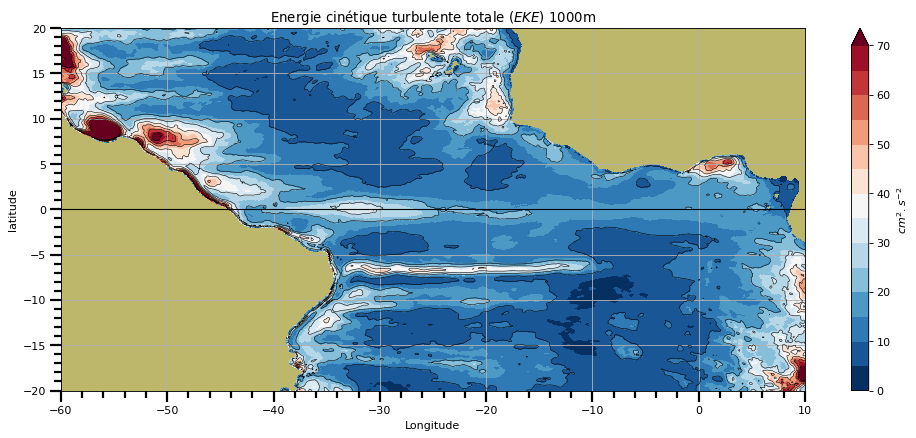

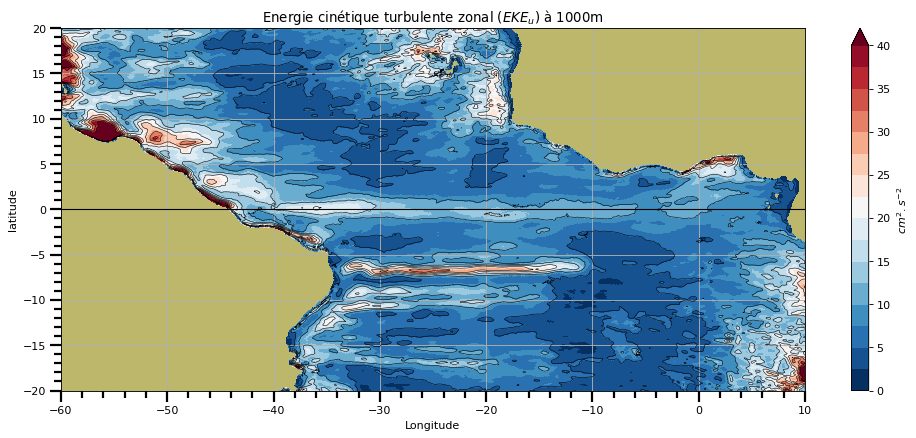

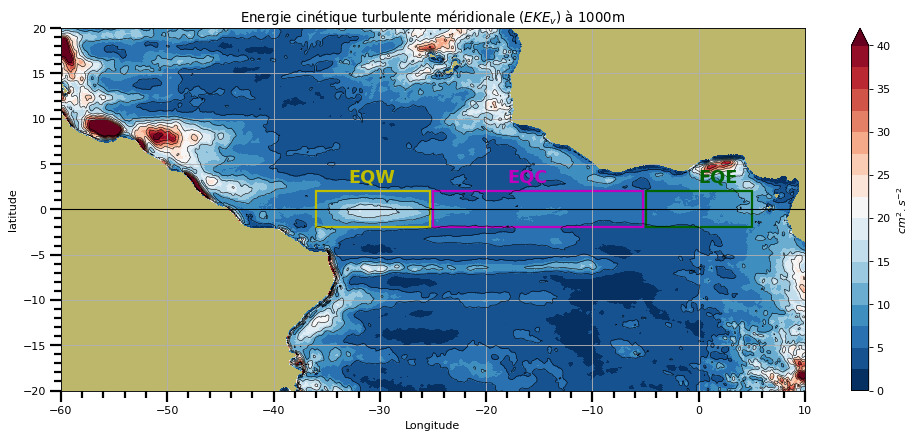

In [12]:
depth=-1000.

###########
# For total
EKE_Total_D = slice2(ds, EKE_Total, z, depth=depth)*10000

plt.figure(figsize=(15,6), dpi=80)


EKE_Total_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',levels=15,cbar_kwargs={'label': '$cm^2.s^{-2}$'})

EKE_Total_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique turbulente totale ($EKE$) '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

##########
# For u
EKE_u_D = slice2(ds, EKE_u, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


EKE_u_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=40,cmap='RdBu_r',levels=17,cbar_kwargs={'label': '$cm^2.s^{-2}$'})

EKE_u_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=40,levels=9,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique turbulente zonal ($EKE_u$) à '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###########
# For v
EKE_v_D = slice2(ds, EKE_v, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)
# plt.rcParams['xtick.labelsize']=16


EKE_v_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=40,cmap='RdBu_r',levels=17,cbar_kwargs={'label': '$cm^2.s^{-2}$'})

EKE_v_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=40,levels=9,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique turbulente méridionale ($EKE_v$) à '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()



# rect = patches.Rectangle((-40,-2),40,4,linewidth=2,edgecolor='r',facecolor='none')
# ax.add_artist(rect)
# plt.text(-18,3,'EQ', fontsize=16, color='r',weight='bold')

rect = patches.Rectangle((-36,-2),10.7,4,linewidth=2,edgecolor='y',facecolor='none')
ax.add_artist(rect)
plt.text(-33,3,'EQW', fontsize=16, color='y',weight='bold')

rect = patches.Rectangle((-25,-2),19.8,4,linewidth=2,edgecolor='m',facecolor='none')
ax.add_artist(rect)
plt.text(-18,3,'EQC', fontsize=16, color='m',weight='bold')

rect = patches.Rectangle((-5,-2),10,4,linewidth=2,edgecolor='darkgreen',facecolor='none')
ax.add_artist(rect)
plt.text(-0.,3,'EQE', fontsize=16, color='darkgreen',weight='bold')

# ax.add_artist(lines.Line2D((-44, -54), (0, 10), color = 'red'))
# ax.add_artist(lines.Line2D((-38, -48), (0, 10), color = 'red'))
# ax.add_artist(lines.Line2D((-54, -48), (10, 10), color = 'red'))
# ax.add_artist(lines.Line2D((-44, -38), (0, 0), color = 'red'))
# plt.text(-52.,11,'WB', fontsize=16, color='r',weight='bold')


# rect = patches.Rectangle((-35,-8),35,4,linewidth=2,edgecolor='r',facecolor='none')
# ax.add_artist(rect)
# plt.text(-7,-8,'TS', fontsize=16, color='r',weight='bold')


# rect = patches.Rectangle((-26,-5),15,3,linewidth=2,edgecolor='y',facecolor='none')
# ax.add_artist(rect)
# plt.text(-10,-4,'EQC', fontsize=16, color='y',weight='bold')

plt.show()

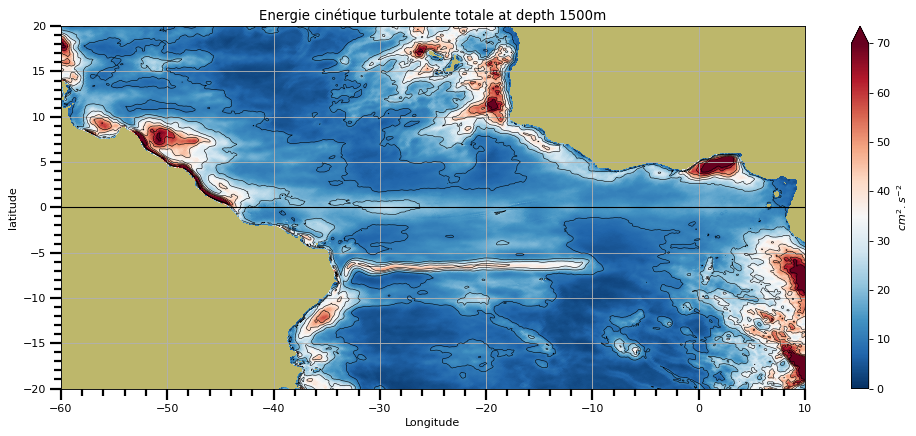

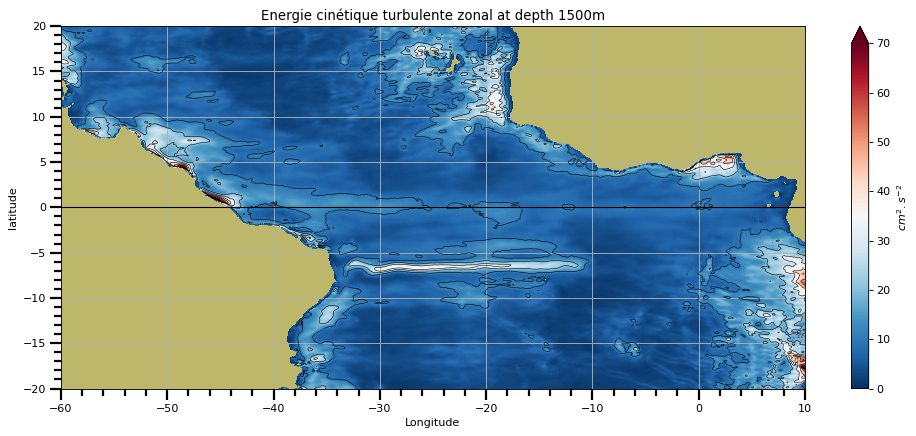

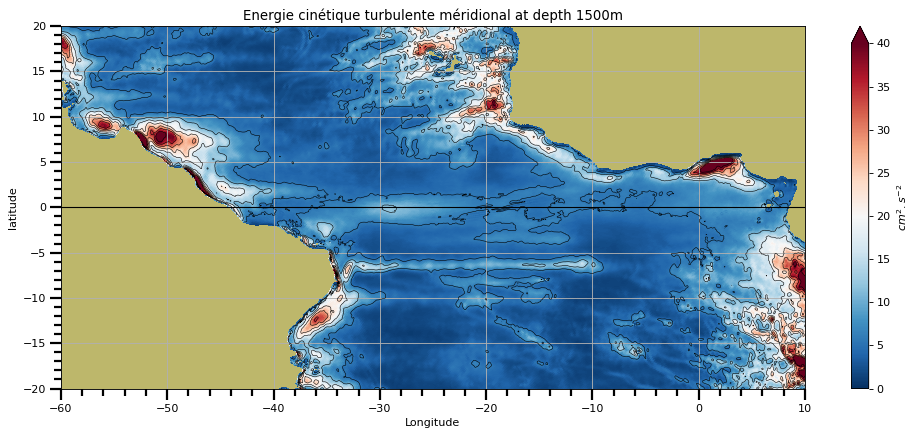

In [16]:
depth=-1500.

############
# For total
EKE_Total_D = slice2(ds, EKE_Total, z, depth=depth)*10000

plt.figure(figsize=(15,6), dpi=80)


EKE_Total_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

EKE_Total_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique turbulente totale at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

##########
# For u
EKE_u_D = slice2(ds, EKE_u, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


EKE_u_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

EKE_u_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique turbulente zonal at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###########
# For v
EKE_v_D = slice2(ds, EKE_v, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


EKE_v_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=40,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

EKE_v_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=40,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique turbulente méridional at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

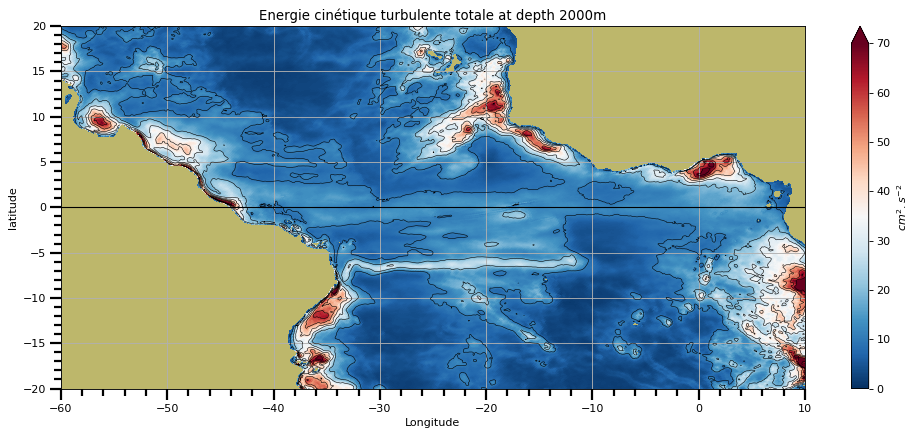

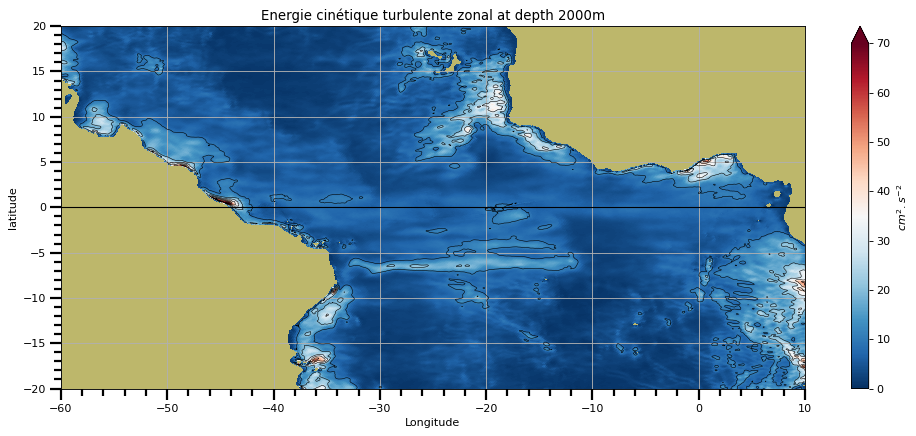

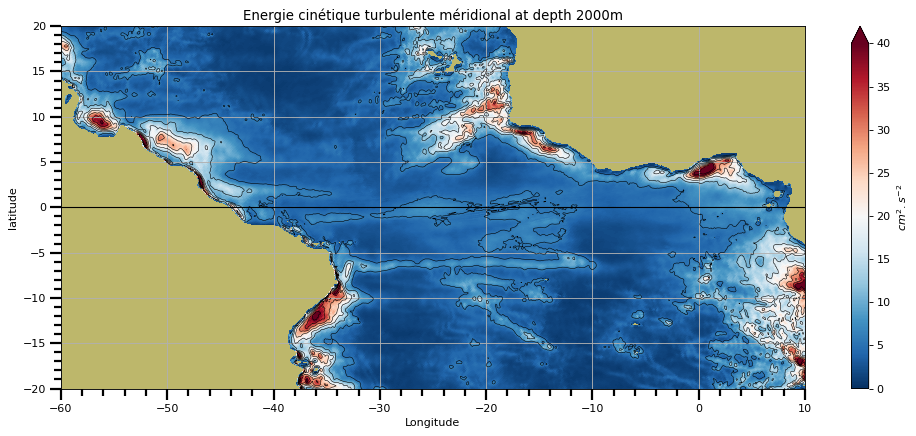

In [17]:
depth=-2000.

############
# For total
EKE_Total_D = slice2(ds, EKE_Total, z, depth=depth)*10000

plt.figure(figsize=(15,6), dpi=80)


EKE_Total_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

EKE_Total_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique turbulente totale at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

##########
# For u
EKE_u_D = slice2(ds, EKE_u, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


EKE_u_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

EKE_u_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique turbulente zonal at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###########
# For v
EKE_v_D = slice2(ds, EKE_v, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


EKE_v_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=40,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

EKE_v_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=40,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique turbulente méridional at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

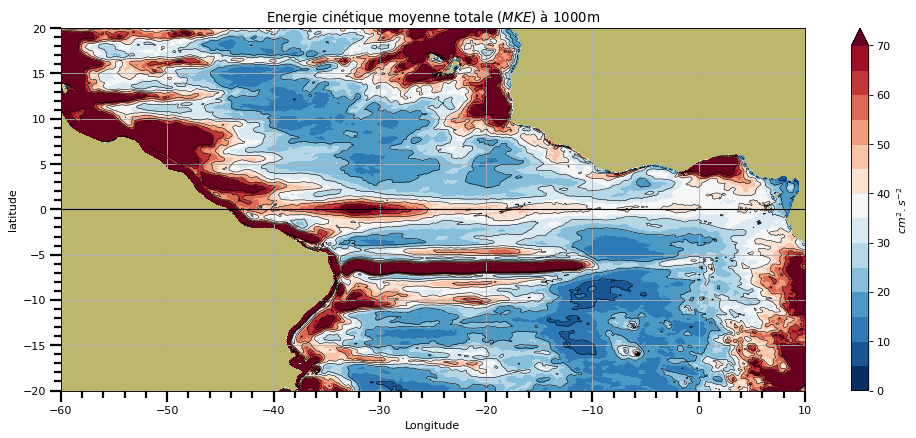

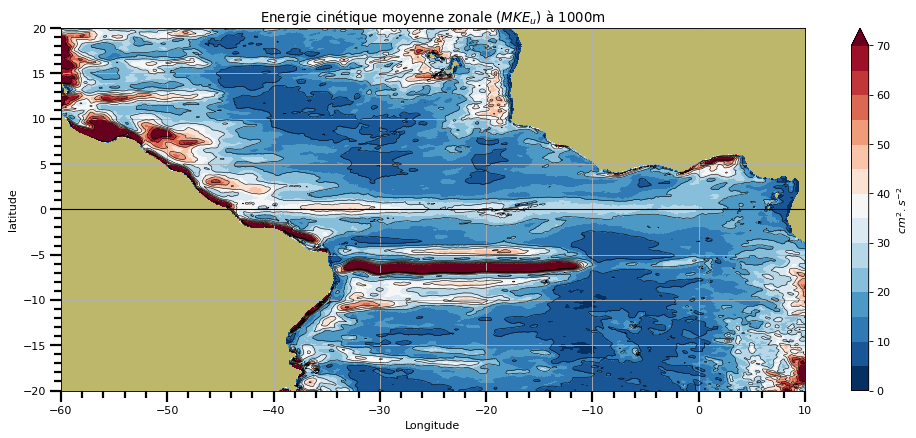

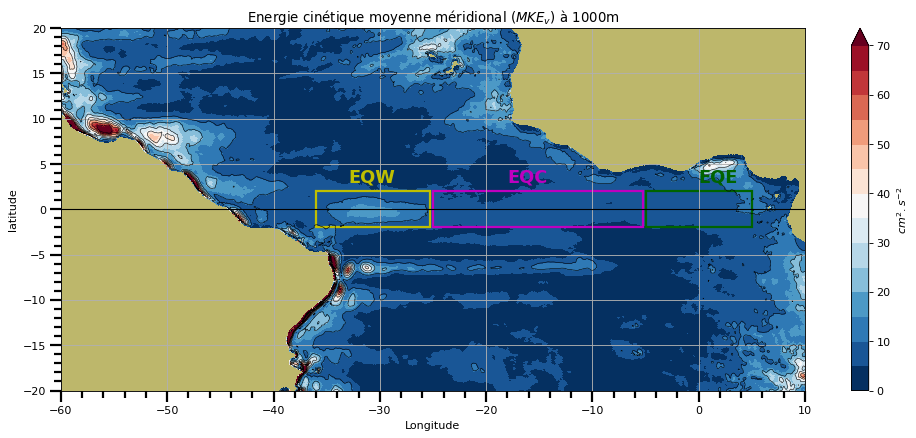

In [17]:
depth=-1000.

###############
## For Total
KE_tot_D = slice2(ds, KE_tot, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


KE_tot_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',levels=15,cbar_kwargs={'label': '$cm^2.s^{-2}$'})

KE_tot_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique moyenne totale ($MKE$) à '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###############
## For u
KE_u_D = slice2(ds, KE_u, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


KE_u_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',levels=15,cbar_kwargs={'label': '$cm^2.s^{-2}$'})

KE_u_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique moyenne zonale ($MKE_u$) à '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###############
## For v
KE_v_D = slice2(ds, KE_v, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


KE_v_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',levels=15,cbar_kwargs={'label': '$cm^2.s^{-2}$'})

KE_v_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique moyenne méridional ($MKE_v$) à '+str(int(abs(depth)))+'m')

ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()



# rect = patches.Rectangle((-40,-2),40,4,linewidth=2,edgecolor='r',facecolor='none')
# ax.add_artist(rect)
# plt.text(-18,3,'EQ', fontsize=16, color='r',weight='bold')

rect = patches.Rectangle((-36,-2),10.7,4,linewidth=2,edgecolor='y',facecolor='none')
ax.add_artist(rect)
plt.text(-33,3,'EQW', fontsize=16, color='y',weight='bold')

rect = patches.Rectangle((-25,-2),19.8,4,linewidth=2,edgecolor='m',facecolor='none')
ax.add_artist(rect)
plt.text(-18,3,'EQC', fontsize=16, color='m',weight='bold')

rect = patches.Rectangle((-5,-2),10,4,linewidth=2,edgecolor='darkgreen',facecolor='none')
ax.add_artist(rect)
plt.text(-0.,3,'EQE', fontsize=16, color='darkgreen',weight='bold')

# ax.add_artist(lines.Line2D((-44, -54), (0, 10), color = 'red'))
# ax.add_artist(lines.Line2D((-38, -48), (0, 10), color = 'red'))
# ax.add_artist(lines.Line2D((-54, -48), (10, 10), color = 'red'))
# ax.add_artist(lines.Line2D((-44, -38), (0, 0), color = 'red'))
# plt.text(-52.,11,'WB', fontsize=16, color='r',weight='bold')


# rect = patches.Rectangle((-35,-8),35,4,linewidth=2,edgecolor='r',facecolor='none')
# ax.add_artist(rect)
# plt.text(-7,-8,'TS', fontsize=16, color='r',weight='bold')


# rect = patches.Rectangle((-26,-5),15,3,linewidth=2,edgecolor='y',facecolor='none')
# ax.add_artist(rect)
# plt.text(-10,-4,'EQC', fontsize=16, color='y',weight='bold')

plt.show()

In [ ]:
depth=-1500.

###############
## For Total
KE_tot_D = slice2(ds, KE_tot, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


KE_tot_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

KE_tot_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique moyenne totale at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###############
## For u
KE_u_D = slice2(ds, KE_u, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


KE_u_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

KE_u_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique moyenne zonale at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###############
## For v
KE_v_D = slice2(ds, KE_v, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


KE_v_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

KE_v_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique moyenne méridional at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

In [ ]:
depth=-2000.

###############
## For Total
KE_tot_D = slice2(ds, KE_tot, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


KE_tot_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

KE_tot_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique moyenne totale at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###############
## For u
KE_u_D = slice2(ds, KE_u, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


KE_u_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

KE_u_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique moyenne zonale at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###############
## For v
KE_v_D = slice2(ds, KE_v, z, depth=depth)*10000


plt.figure(figsize=(15,6), dpi=80)


KE_v_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=70,cmap='RdBu_r',cbar_kwargs={'label': '$cm^2.s^{-2}$'})

KE_v_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=70,levels=8,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Energie cinétique moyenne méridional at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

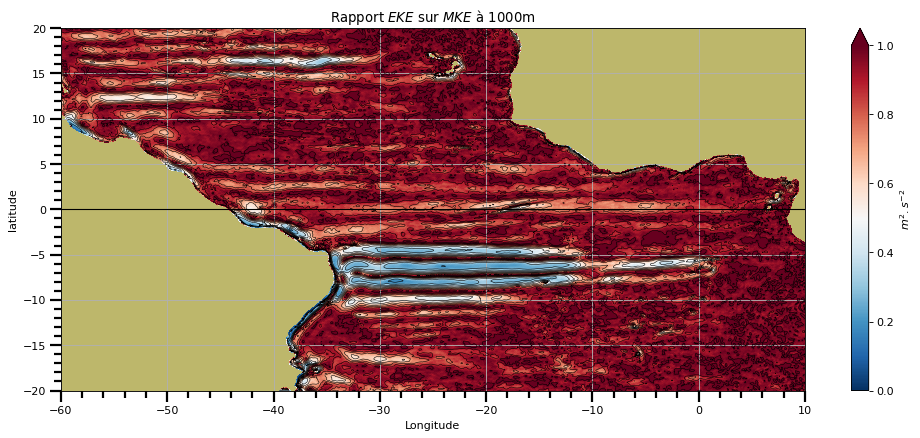

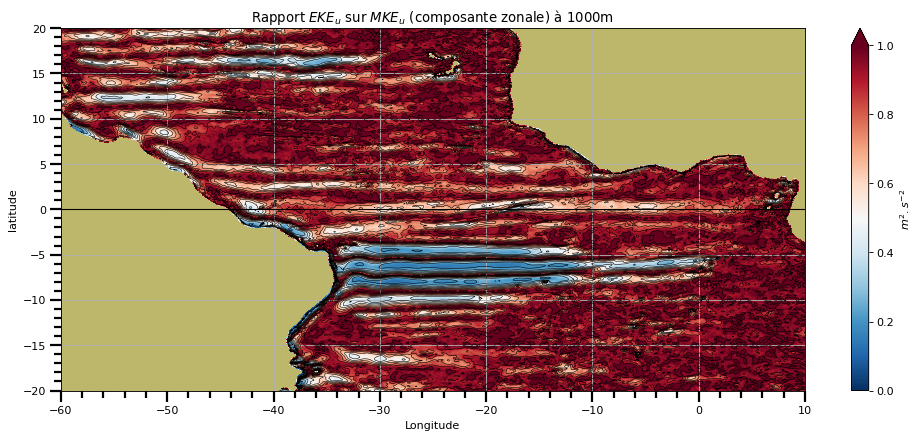

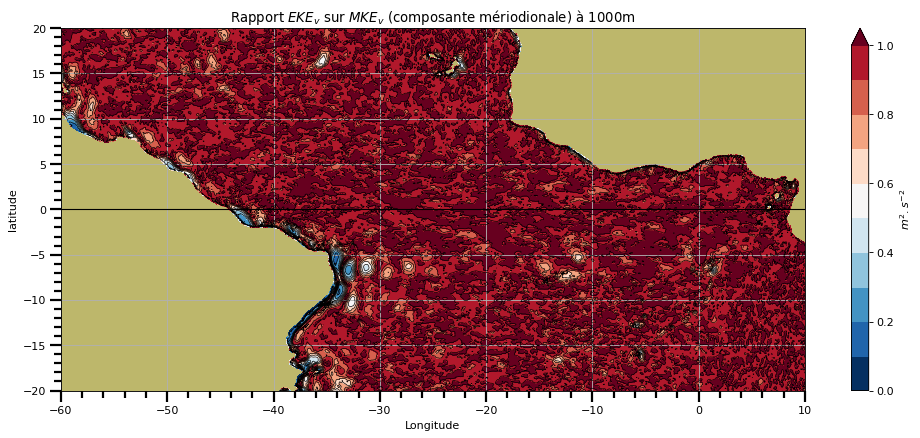

In [22]:
depth=-1000.

###############
## For Total
KE_Total_rapport_D = slice2(ds, KE_Total_rapport, z, depth=depth)


plt.figure(figsize=(15,6), dpi=80)


KE_Total_rapport_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

KE_Total_rapport_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=1,levels=11,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Rapport $EKE$ sur $MKE$ à '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###############
## For u
KE_u_rapport_D = slice2(ds, KE_u_rapport, z, depth=depth)


plt.figure(figsize=(15,6), dpi=80)


KE_u_rapport_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

KE_u_rapport_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=1,levels=11,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Rapport $EKE_u$ sur $MKE_u$ (composante zonale) à '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###############
## For v
KE_v_rapport_D = slice2(ds, KE_v_rapport, z, depth=depth)


plt.figure(figsize=(15,6), dpi=80)


KE_v_rapport_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=1,levels=11,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

KE_v_rapport_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=1.,levels=11,colors='black',
                             linewidths=0.6)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Rapport $EKE_v$ sur $MKE_v$ (composante mériodionale) à '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

In [ ]:
np.nanmax(KE_v_rapport_D.values)

In [ ]:
depth=-1500.

###############
## For Total
KE_Total_rapport_D = slice2(ds, KE_Total_rapport, z, depth=depth)


plt.figure(figsize=(15,6), dpi=80)


KE_Total_rapport_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

KE_Total_rapport_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=1,levels=11,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Rapport Energie cinétique turbulente sur Energie cinétique moyenne totale at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###############
## For u
KE_u_rapport_D = slice2(ds, KE_u_rapport, z, depth=depth)


plt.figure(figsize=(15,6), dpi=80)


KE_u_rapport_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

KE_u_rapport_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=1,levels=11,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Rapport Energie cinétique turbulente sur Energie cinétique moyenne zonale at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid())

###############
## For v
KE_v_rapport_D = slice2(ds, KE_v_rapport, z, depth=depth)


plt.figure(figsize=(15,6), dpi=80)


KE_v_rapport_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

KE_v_rapport_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=1,levels=11,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Rapport Energie cinétique turbulente sur Energie cinétique moyenne méridional at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

In [ ]:
depth=-2000.

###############
## For Total
KE_Total_rapport_D = slice2(ds, KE_Total_rapport, z, depth=depth)


plt.figure(figsize=(15,6), dpi=80)


KE_Total_rapport_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

KE_Total_rapport_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=1,levels=11,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Rapport Energie cinétique turbulente sur Energie cinétique moyenne totale at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()

###############
## For u
KE_u_rapport_D = slice2(ds, KE_u_rapport, z, depth=depth)


plt.figure(figsize=(15,6), dpi=80)


KE_u_rapport_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

KE_u_rapport_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=1,levels=11,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Rapport Energie cinétique turbulente sur Energie cinétique moyenne zonale at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid())

###############
## For v
KE_v_rapport_D = slice2(ds, KE_v_rapport, z, depth=depth)


plt.figure(figsize=(15,6), dpi=80)


KE_v_rapport_D.plot(x=[s for s in ds.coords if "xi_" in s][0],
                       y=[s for s in ds.coords if "eta_" in s][0],
                     vmin=0,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': '$m^2.s^{-2}$'})

KE_v_rapport_D.plot.contour(x=[s for s in ds.coords if "xi_" in s][0],
                             y=[s for s in ds.coords if "eta_" in s][0],
                             vmin=0,vmax=1,levels=11,colors='black',
                             linewidths=0.5)

plt.xlim(-60,10)
plt.ylim(-20,20)
plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.axhline(y=-0.,color='black',linewidth=1)
plt.title('Rapport Energie cinétique turbulente sur Energie cinétique moyenne méridional at depth '+str(int(abs(depth)))+'m')
ax = plt.gca()
ax.set_facecolor('darkkhaki')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=6, color='black')

plt.grid()